In [1]:
import torch
import torch.utils.data
import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from tqdm import tqdm
from PIL import Image, ImageOps

import torch.nn as nn

import models.MathNet as mnt
import models.MathNet56 as mnt56

In [2]:
BATCH_SIZE = 128
EPOCHS = 31
IMAGE_SIZE = 56

In [3]:
# the training transforms
train_transform = transforms.Compose([
    transforms.Grayscale(1),
    transforms.ToTensor()
    #transforms.Normalize(std=0.5, mean=0.2)
    
])
# the validation transforms
valid_transform = transforms.Compose([
    transforms.Grayscale(1),
    transforms.ToTensor()
])

In [4]:
dataset = torchvision.datasets.ImageFolder(r'TRAIN\all_dataset56', transform=train_transform)
print(len(dataset))

338209


In [5]:
classes_dict = dataset.class_to_idx
classes = []
for key in classes_dict.keys():
    classes.append(str(key))
classes.sort()
classes

['(',
 ')',
 '+',
 ',',
 '-',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'A',
 'F',
 'alpha',
 'and',
 'beta',
 'delta',
 'exists',
 'forall',
 'gamma',
 'lambda',
 'mu',
 'not',
 'omega',
 'or',
 'phi',
 'pi',
 'psi',
 'rightarrow',
 'sigma',
 'tau',
 'theta',
 'upsilon',
 'x',
 'y',
 'z']

In [6]:
# classes = ['(', ')', ',', '-', 
#                    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
#                    'A', '[', 'α', 'and', 'β', '∃', 'F', '∀', 
#                    'γ', 'λ', 'μ', 'ω', 'or', 'φ', '→', 
#                    'σ', 'sqrt', 'θ', 'v', 'x', 'y', 'z']

NUM_CLASSES = len(classes)

def map_pred(ind):
    if ind < NUM_CLASSES:
        return classes[ind]
    return 'ERROR MAPPIMG'

NUM_CLASSES

40

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
device

device(type='cuda', index=0)

In [8]:
def add_contrast(x, factor):
    return transforms.functional.adjust_contrast(x, factor)

In [9]:
mean, std = dataset[0][0].mean(), dataset[0][0].std()
print(mean, std)

tensor(0.7809) tensor(0.3949)


In [10]:
def train_val_dataset(dataset, val_split=0.2):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

In [11]:
datasets = train_val_dataset(dataset)
print(type(datasets['train']))
print(len(datasets['val']))
# The original dataset is avail


<class 'torch.utils.data.dataset.Subset'>
67642


In [12]:
print(dataset)

Dataset ImageFolder
    Number of datapoints: 338209
    Root location: TRAIN\all_dataset56
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               ToTensor()
           )


67642


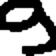

In [13]:
# training dataset
train_dataset = datasets['train']
# validation dataset
valid_dataset = (datasets['val'])
# training data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=6, pin_memory=True
)
# validation data loaders
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=6, pin_memory=True
)
# training data loaders
dataset[0]
print(len(valid_dataset))
#print(valid_dataset.dataset.targets)
aaa = transforms.ToPILImage()
display(aaa(valid_dataset[15451][0]))

In [14]:
from collections import Counter


In [15]:
d = dict(Counter(valid_dataset.dataset.targets))
print(d)

{0: 14293, 1: 14355, 2: 9464, 3: 1906, 4: 15834, 5: 12826, 6: 16968, 7: 11884, 8: 11760, 9: 14853, 10: 12589, 11: 8749, 12: 12158, 13: 12189, 14: 9976, 15: 14407, 16: 7480, 17: 7284, 18: 5634, 19: 5421, 20: 1246, 21: 5896, 22: 16053, 23: 2861, 24: 1105, 25: 1623, 26: 10350, 27: 12527, 28: 5043, 29: 3806, 30: 5775, 31: 1115, 32: 4140, 33: 1525, 34: 608, 35: 6918, 36: 3506, 37: 17559, 38: 9454, 39: 7069}


<Axes: ylabel='Сharactrs'>

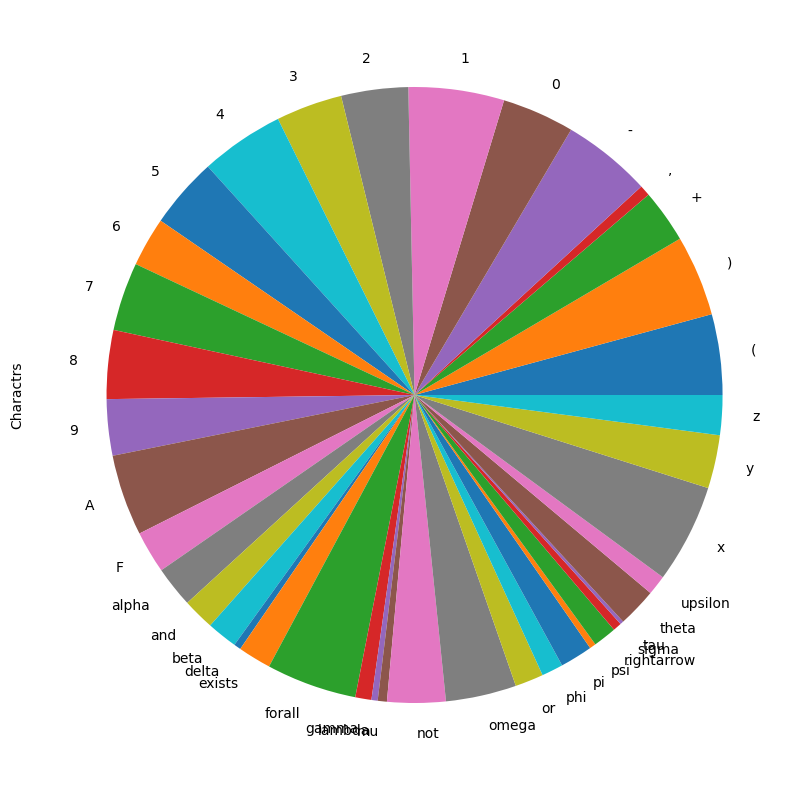

In [16]:
import pandas as pd
df = pd.Series(data=d,name='Сharactrs')    
df.plot(labels=classes,kind='pie',figsize=(10,10))

In [17]:
# training
def train(model, trainloader, optimizer, loss_function):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=int(len(trainloader))):
        counter += 1
        optimizer.zero_grad()
        x, y = data
        x = x.to(device)      
        y = y.to(device)       
        outputs = model.forward(x)
        loss = loss_function(outputs, y)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == y).sum().item()
        loss.backward()
        optimizer.step()
    
    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

In [18]:
def validate(model, testloader, loss_function):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=int(len(testloader))):
            counter += 1
            x, y = data
            x = x.to(device)      
            y = y.to(device)
            # forward pass
            outputs = model(x)
            # calculate the loss
            loss = loss_function(outputs, y)
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == y).sum().item()
        
    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [19]:
if (IMAGE_SIZE == 56):
    model = mnt56.MathNet56()
elif (IMAGE_SIZE == 224):
    model = mnt.MathNet()

torch.cuda.empty_cache()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
model = model.to(device)
device
type(model)

models.MathNet56.MathNet56

In [20]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-4)

In [21]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss, label=''):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig('outputs/mathnet'+str(IMAGE_SIZE)+'_accuracy'+label+'.png')
    
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('outputs/mathnet'+str(IMAGE_SIZE)+'_loss'+label+'.png')

[INFO]: Epoch 1 of 31
Training


100%|██████████| 2114/2114 [04:30<00:00,  7.80it/s]


Validation


100%|██████████| 529/529 [00:21<00:00, 24.40it/s]


Training loss: 0.083, training acc: 97.687
Validation loss: 0.093, validation acc: 97.225
--------------------------------------------------
[INFO]: Epoch 2 of 31
Training


100%|██████████| 2114/2114 [04:31<00:00,  7.78it/s]


Validation


100%|██████████| 529/529 [00:21<00:00, 24.91it/s]


Training loss: 0.069, training acc: 97.996
Validation loss: 0.064, validation acc: 98.080
--------------------------------------------------
[INFO]: Epoch 3 of 31
Training


100%|██████████| 2114/2114 [04:35<00:00,  7.68it/s]


Validation


100%|██████████| 529/529 [00:21<00:00, 24.62it/s]


Training loss: 0.060, training acc: 98.217
Validation loss: 0.062, validation acc: 98.155
--------------------------------------------------
[INFO]: Epoch 4 of 31
Training


100%|██████████| 2114/2114 [04:34<00:00,  7.71it/s]


Validation


100%|██████████| 529/529 [00:21<00:00, 24.29it/s]


Training loss: 0.052, training acc: 98.437
Validation loss: 0.060, validation acc: 98.190
--------------------------------------------------
[INFO]: Epoch 5 of 31
Training


100%|██████████| 2114/2114 [04:33<00:00,  7.72it/s]


Validation


100%|██████████| 529/529 [00:21<00:00, 24.77it/s]


Training loss: 0.047, training acc: 98.558
Validation loss: 0.049, validation acc: 98.494
--------------------------------------------------
[INFO]: Epoch 6 of 31
Training


100%|██████████| 2114/2114 [04:29<00:00,  7.86it/s]


Validation


100%|██████████| 529/529 [00:21<00:00, 24.85it/s]


Training loss: 0.042, training acc: 98.715
Validation loss: 0.046, validation acc: 98.604
--------------------------------------------------
[INFO]: Epoch 7 of 31
Training


100%|██████████| 2114/2114 [04:31<00:00,  7.79it/s]


Validation


100%|██████████| 529/529 [00:21<00:00, 24.82it/s]


Training loss: 0.038, training acc: 98.805
Validation loss: 0.044, validation acc: 98.661
--------------------------------------------------
[INFO]: Epoch 8 of 31
Training


100%|██████████| 2114/2114 [04:28<00:00,  7.86it/s]


Validation


100%|██████████| 529/529 [00:21<00:00, 24.87it/s]


Training loss: 0.035, training acc: 98.913
Validation loss: 0.048, validation acc: 98.471
--------------------------------------------------
[INFO]: Epoch 9 of 31
Training


100%|██████████| 2114/2114 [04:33<00:00,  7.72it/s]


Validation


100%|██████████| 529/529 [00:22<00:00, 23.79it/s]


Training loss: 0.031, training acc: 99.023
Validation loss: 0.041, validation acc: 98.755
--------------------------------------------------
[INFO]: Epoch 10 of 31
Training


100%|██████████| 2114/2114 [04:32<00:00,  7.75it/s]


Validation


100%|██████████| 529/529 [00:21<00:00, 24.53it/s]


Training loss: 0.029, training acc: 99.082
Validation loss: 0.037, validation acc: 98.927
--------------------------------------------------
[INFO]: Epoch 11 of 31
Training


100%|██████████| 2114/2114 [04:33<00:00,  7.72it/s]


Validation


100%|██████████| 529/529 [00:21<00:00, 24.60it/s]


Training loss: 0.027, training acc: 99.156
Validation loss: 0.033, validation acc: 99.046
--------------------------------------------------
[INFO]: Epoch 12 of 31
Training


100%|██████████| 2114/2114 [04:30<00:00,  7.81it/s]


Validation


100%|██████████| 529/529 [00:21<00:00, 24.93it/s]


Training loss: 0.024, training acc: 99.218
Validation loss: 0.037, validation acc: 98.921
--------------------------------------------------
[INFO]: Epoch 13 of 31
Training


100%|██████████| 2114/2114 [04:28<00:00,  7.86it/s]


Validation


100%|██████████| 529/529 [00:21<00:00, 24.83it/s]


Training loss: 0.023, training acc: 99.277
Validation loss: 0.033, validation acc: 99.042
--------------------------------------------------
[INFO]: Epoch 14 of 31
Training


100%|██████████| 2114/2114 [04:30<00:00,  7.80it/s]


Validation


100%|██████████| 529/529 [00:21<00:00, 24.86it/s]


Training loss: 0.021, training acc: 99.342
Validation loss: 0.037, validation acc: 98.939
--------------------------------------------------
[INFO]: Epoch 15 of 31
Training


100%|██████████| 2114/2114 [04:28<00:00,  7.86it/s]


Validation


100%|██████████| 529/529 [00:21<00:00, 24.73it/s]


Training loss: 0.020, training acc: 99.375
Validation loss: 0.035, validation acc: 99.005
--------------------------------------------------
[INFO]: Epoch 16 of 31
Training


100%|██████████| 2114/2114 [04:29<00:00,  7.84it/s]


Validation


100%|██████████| 529/529 [00:21<00:00, 24.81it/s]


Training loss: 0.017, training acc: 99.443
Validation loss: 0.033, validation acc: 99.042
--------------------------------------------------
[INFO]: Epoch 17 of 31
Training


100%|██████████| 2114/2114 [04:28<00:00,  7.87it/s]


Validation


100%|██████████| 529/529 [00:21<00:00, 24.96it/s]


Training loss: 0.016, training acc: 99.476
Validation loss: 0.031, validation acc: 99.098
--------------------------------------------------
[INFO]: Epoch 18 of 31
Training


100%|██████████| 2114/2114 [04:28<00:00,  7.86it/s]


Validation


100%|██████████| 529/529 [00:21<00:00, 24.99it/s]


Training loss: 0.015, training acc: 99.501
Validation loss: 0.031, validation acc: 99.135
--------------------------------------------------
[INFO]: Epoch 19 of 31
Training


100%|██████████| 2114/2114 [04:29<00:00,  7.84it/s]


Validation


100%|██████████| 529/529 [00:21<00:00, 24.55it/s]


Training loss: 0.014, training acc: 99.546
Validation loss: 0.030, validation acc: 99.162
--------------------------------------------------
[INFO]: Epoch 20 of 31
Training


100%|██████████| 2114/2114 [04:31<00:00,  7.78it/s]


Validation


100%|██████████| 529/529 [00:21<00:00, 24.09it/s]


Training loss: 0.013, training acc: 99.562
Validation loss: 0.032, validation acc: 99.169
--------------------------------------------------
[INFO]: Epoch 21 of 31
Training


100%|██████████| 2114/2114 [04:31<00:00,  7.79it/s]


Validation


100%|██████████| 529/529 [00:21<00:00, 24.70it/s]


Training loss: 0.012, training acc: 99.597
Validation loss: 0.028, validation acc: 99.277
--------------------------------------------------
[INFO]: Epoch 22 of 31
Training


100%|██████████| 2114/2114 [04:31<00:00,  7.80it/s]


Validation


100%|██████████| 529/529 [00:21<00:00, 24.81it/s]


Training loss: 0.011, training acc: 99.622
Validation loss: 0.030, validation acc: 99.224
--------------------------------------------------
[INFO]: Epoch 23 of 31
Training


100%|██████████| 2114/2114 [04:29<00:00,  7.85it/s]


Validation


100%|██████████| 529/529 [00:21<00:00, 25.14it/s]


Training loss: 0.011, training acc: 99.629
Validation loss: 0.026, validation acc: 99.336
--------------------------------------------------
[INFO]: Epoch 24 of 31
Training


100%|██████████| 2114/2114 [04:28<00:00,  7.86it/s]


Validation


100%|██████████| 529/529 [00:21<00:00, 24.80it/s]


Training loss: 0.010, training acc: 99.673
Validation loss: 0.028, validation acc: 99.282
--------------------------------------------------
[INFO]: Epoch 25 of 31
Training


100%|██████████| 2114/2114 [04:28<00:00,  7.87it/s]


Validation


100%|██████████| 529/529 [00:21<00:00, 24.82it/s]


Training loss: 0.009, training acc: 99.676
Validation loss: 0.030, validation acc: 99.206
--------------------------------------------------
[INFO]: Epoch 26 of 31
Training


100%|██████████| 2114/2114 [04:28<00:00,  7.88it/s]


Validation


100%|██████████| 529/529 [00:21<00:00, 24.93it/s]


Training loss: 0.009, training acc: 99.701
Validation loss: 0.027, validation acc: 99.293
--------------------------------------------------
[INFO]: Epoch 27 of 31
Training


100%|██████████| 2114/2114 [04:29<00:00,  7.85it/s]


Validation


100%|██████████| 529/529 [00:21<00:00, 24.37it/s]


Training loss: 0.009, training acc: 99.710
Validation loss: 0.026, validation acc: 99.344
--------------------------------------------------
[INFO]: Epoch 28 of 31
Training


100%|██████████| 2114/2114 [04:25<00:00,  7.96it/s]


Validation


100%|██████████| 529/529 [00:21<00:00, 24.65it/s]


Training loss: 0.009, training acc: 99.713
Validation loss: 0.025, validation acc: 99.364
--------------------------------------------------
[INFO]: Epoch 29 of 31
Training


100%|██████████| 2114/2114 [04:32<00:00,  7.75it/s]


Validation


100%|██████████| 529/529 [00:21<00:00, 24.99it/s]


Training loss: 0.008, training acc: 99.729
Validation loss: 0.028, validation acc: 99.341
--------------------------------------------------
[INFO]: Epoch 30 of 31
Training


100%|██████████| 2114/2114 [04:30<00:00,  7.83it/s]


Validation


100%|██████████| 529/529 [00:21<00:00, 24.75it/s]


Training loss: 0.007, training acc: 99.743
Validation loss: 0.029, validation acc: 99.284
--------------------------------------------------
[INFO]: Epoch 31 of 31
Training


100%|██████████| 2114/2114 [04:29<00:00,  7.84it/s]


Validation


100%|██████████| 529/529 [00:21<00:00, 24.68it/s]


Training loss: 0.008, training acc: 99.741
Validation loss: 0.025, validation acc: 99.379
--------------------------------------------------
TRAINING COMPLETE


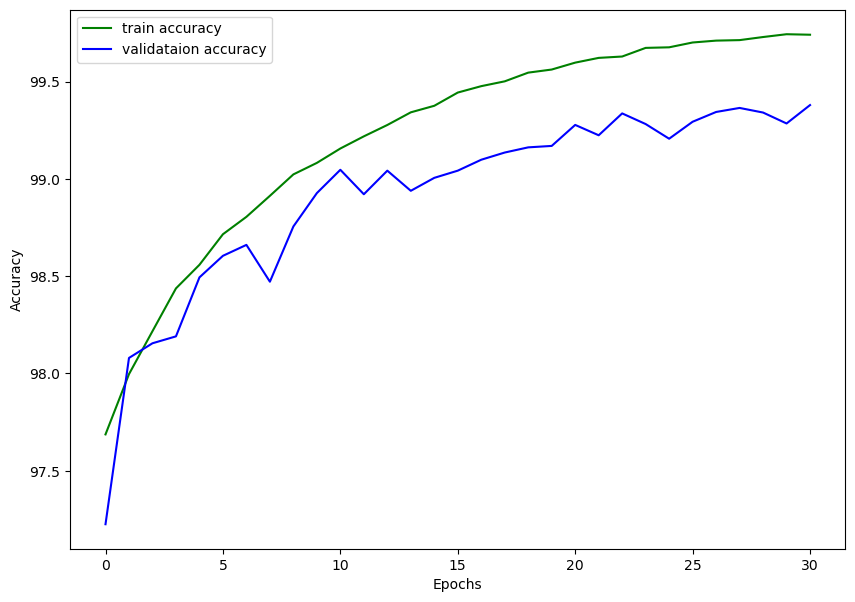

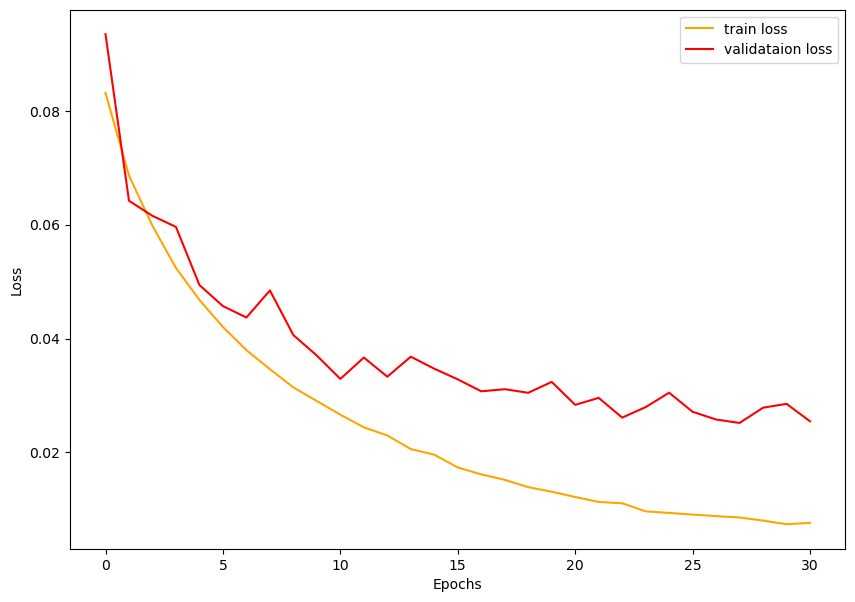

In [23]:
# lists to keep track of losses and accuracies
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# start the training
for epoch in range(EPOCHS):
    print(f"[INFO]: Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, 
                                              optimizer, loss)
    valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader,  
                                                 loss)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print('-'*50)
    
    torch.save(model.state_dict(), 'models/mathnet'+str(IMAGE_SIZE)+'/mathnet'+str(epoch)+'.ml')
    
# save the trained model weights
torch.save(model.state_dict(), 'models/mathnet'+str(IMAGE_SIZE)+'/mathnet.ml')
# save the loss and accuracy plots
save_plots(train_acc, valid_acc, train_loss, valid_loss)
print('TRAINING COMPLETE')

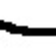

tensor([[ -83.3832, -113.8964,  -64.7247,  -68.1926,   64.7510, -130.7555,
          -67.2288,  -77.7639, -142.5658,  -68.5426,  -86.6750,  -84.9524,
          -49.7882, -147.7066,  -82.2921, -126.5089,  -80.5182,  -32.7107,
          -69.7015, -129.9898, -121.7209,  -94.0612,  -80.5067,  -84.2101,
         -105.3413,  -95.6218,  -85.0578,  -97.7187, -108.8317,  -59.3155,
          -77.0165,  -71.7606,  -27.9578,  -72.8503,  -68.7685,  -99.2505,
         -143.7744,  -74.0456, -104.3796,  -75.6333]], device='cuda:0',
       grad_fn=<MulBackward0>) -


In [26]:
import cv2
from PIL import Image, ImageOps

img = Image.open("TEST/0.jpg")
#print(img.shape)
convert_tensor = transforms.Compose([
    transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
    transforms.Grayscale(1),
    transforms.ToTensor()

])        
x_image = convert_tensor(img)

aaa = transforms.ToPILImage()
display(aaa(x_image))

x_image = x_image.unsqueeze(0).float()
x_image = x_image.to(device)

pred = model(x_image) 
print(pred*10, map_pred(pred.argmax().item()))

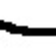

tensor([[ -83.3832, -113.8964,  -64.7247,  -68.1926,   64.7510, -130.7555,
          -67.2288,  -77.7639, -142.5658,  -68.5426,  -86.6750,  -84.9524,
          -49.7882, -147.7066,  -82.2921, -126.5089,  -80.5182,  -32.7107,
          -69.7015, -129.9898, -121.7209,  -94.0612,  -80.5067,  -84.2101,
         -105.3413,  -95.6218,  -85.0578,  -97.7187, -108.8317,  -59.3155,
          -77.0165,  -71.7606,  -27.9578,  -72.8503,  -68.7685,  -99.2505,
         -143.7744,  -74.0456, -104.3796,  -75.6333]], device='cuda:0',
       grad_fn=<MulBackward0>) -


In [31]:
import cv2
from PIL import Image, ImageOps

m = mnt56.MathNet56()
m.load_state_dict(torch.load('models/mathnet'+str(IMAGE_SIZE)+'/mathnet.ml'))
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
m = m.to(device)
m.eval()

img = Image.open("TEST/0.jpg")
#print(img.shape)
convert_tensor = transforms.Compose([
    transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
    transforms.Grayscale(1),
    transforms.ToTensor()

])        
x_image = convert_tensor(img)

aaa = transforms.ToPILImage()
display(aaa(x_image))

x_image = x_image.unsqueeze(0).float()
x_image = x_image.to(device)

pred = m(x_image) 
print(pred*10, map_pred(pred.argmax().item()))